### Image Classification with Pretrained ResNet-18 in PyTorch

# Objectives

Develop an image classification model using a pretrained ResNet-18 network.

Apply data augmentation techniques to improve model generalization.

Fine-tune the model on a custom dataset for accurate predictions.

Evaluate model performance using training and validation accuracy.

Provide a reusable pipeline for training and testing image classification tasks.

# Importing required libraries

In [132]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Data Transformations

#### Training images :
resized to 224×224, randomly flipped and rotated, converted to tensors, and normalized.

#### Validation images: 
resized, converted to tensors, and normalized (no augmentation).

In [133]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

##### Dataset : images are loaded from dataset/train and dataset/validation using ImageFolder.
 
##### Transformations: training and validation transforms are applied.

##### DataLoader:  batches of 32 images are created; training data is shuffled, validation data is not.

##### Classes:  class_names stores all class labels in the datase

In [134]:
train_dataset = datasets.ImageFolder("dataset/train", transform=train_transforms)
val_dataset = datasets.ImageFolder("dataset/validation", transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,drop_last=False)
    
class_names = train_dataset.classes
print(class_names)


['fresh_apple', 'fresh_banana', 'fresh_strewberry', 'rotten_apple', 'rotten_banana', 'rotten_strewberry']


In [135]:
class_names = train_dataset.classes
print(class_names)

['fresh_apple', 'fresh_banana', 'fresh_strewberry', 'rotten_apple', 'rotten_banana', 'rotten_strewberry']


#### Batch & Classes

Loads one batch of training images and labels.

Counts the total number of classes in the dataset.

In [136]:
images, labels = next(iter(train_loader))
num_classes = len(train_dataset.classes)

### Device Setup

Checks if a GPU (CUDA) is available; if not, uses the CPU.

Ensures the model and data run on the best available device for faster training.

In [137]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model Setup

Loads a pretrained ResNet-18 model.

Freezes all existing layers so only the final layer will be trained.

Replaces the fully connected (fc) layer to match the number of classes in the dataset.

Moves the model to the selected device (GPU or CPU).

In [138]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

c:\Users\beach\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\beach\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Loss Function & Optimizer

Loss: CrossEntropyLoss for multi-class classification.

Optimizer: Adam updates only the final layer (fc) with a learning rate of 0.0001.

In [139]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

## Training Model

Trains the model for 15 epochs.

For each batch:

Moves images and labels to the device (GPU/CPU).

Computes predictions and loss.

Backpropagates the loss and updates the final layer weights.

Tracks running loss and training accuracy for each epoch.

Prints loss and accuracy after every epoch.

In [140]:
num_epochs = 15
train_loss_history = []
train_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / len(train_dataset)
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")


Epoch 1/15 | Train Loss: 1.6064 | Train Acc: 0.3734
Epoch 2/15 | Train Loss: 1.4195 | Train Acc: 0.5064
Epoch 3/15 | Train Loss: 1.2855 | Train Acc: 0.6157
Epoch 4/15 | Train Loss: 1.1879 | Train Acc: 0.6539
Epoch 5/15 | Train Loss: 1.0947 | Train Acc: 0.7067
Epoch 6/15 | Train Loss: 1.0325 | Train Acc: 0.7377
Epoch 7/15 | Train Loss: 0.9768 | Train Acc: 0.7541
Epoch 8/15 | Train Loss: 0.8949 | Train Acc: 0.7905
Epoch 9/15 | Train Loss: 0.8414 | Train Acc: 0.7960
Epoch 10/15 | Train Loss: 0.7959 | Train Acc: 0.8124
Epoch 11/15 | Train Loss: 0.7143 | Train Acc: 0.8233
Epoch 12/15 | Train Loss: 0.6848 | Train Acc: 0.8233
Epoch 13/15 | Train Loss: 0.6812 | Train Acc: 0.8324
Epoch 14/15 | Train Loss: 0.6164 | Train Acc: 0.8798
Epoch 15/15 | Train Loss: 0.5947 | Train Acc: 0.8652


## Model Evaluation

Switches the model to evaluation mode (model.eval()).

Disables gradient computation with torch.no_grad() for faster inference.

For each batch in the validation set:

Moves images and labels to the device.

Computes predictions and loss.

Counts correct predictions.

Calculates and prints the overall validation accuracy.


Validation Loss: 0.6313 | Validation Acc: 0.8785

Classification Report:
                   precision    recall  f1-score   support

      fresh_apple       0.91      0.98      0.95        62
     fresh_banana       1.00      0.62      0.76        13
 fresh_strewberry       0.78      1.00      0.88        51
     rotten_apple       0.95      0.67      0.78        27
    rotten_banana       0.90      1.00      0.95        46
rotten_strewberry       1.00      0.27      0.42        15

         accuracy                           0.88       214
        macro avg       0.92      0.76      0.79       214
     weighted avg       0.90      0.88      0.86       214



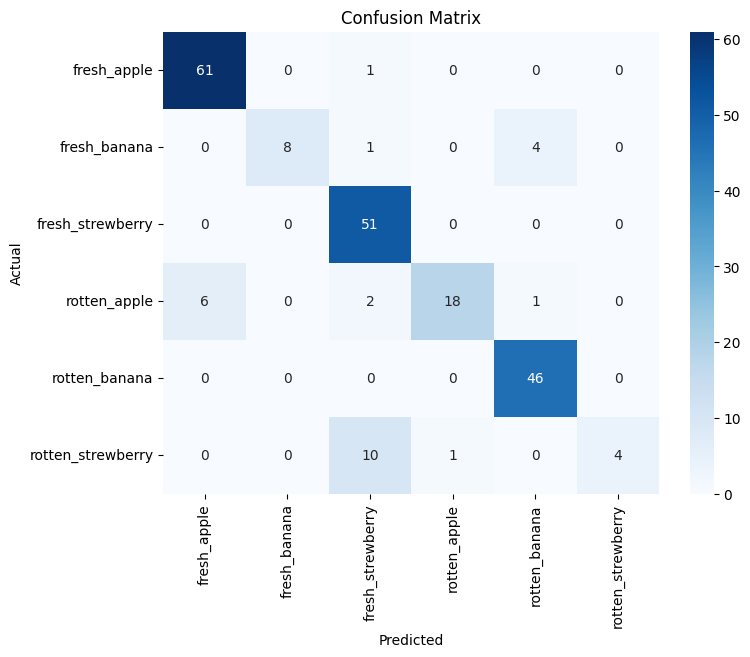

In [141]:
model.eval()
val_running_loss = 0
val_correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        val_running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        val_correct += (preds == labels).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

val_loss = val_running_loss / len(val_loader)
val_acc = val_correct / len(val_dataset)

print(f"\nValidation Loss: {val_loss:.4f} | Validation Acc: {val_acc:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [142]:
torch.save(model.state_dict(), "resnet18_fruits.pth")

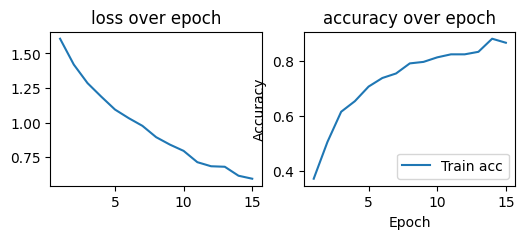

In [143]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=[6,2])
plt.subplot(121);plt.plot(epochs, train_loss_history, label='Train Loss');plt.title('loss over epoch')
plt.subplot(122);plt.plot(epochs, train_acc_history, label='Train acc');plt.title('accuracy over epoch')
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Accuracy')
plt.show()